# Sentiment Analysis of Amazon Fine Food Reviews

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
import pickle

# 3. Data Preparation

### Load data

In [2]:
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.shape

(568454, 10)

# Data cleaning

## Handling missing values

In [4]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


### Remove rows which are having null values

In [5]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 43

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


### Remove duplicate rows

In [6]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174750

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


### Remove outliers

In [7]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


### Create target column using Score

In [44]:
## `Score` > 3 : "Positive" 
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):
    
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [45]:
# target column 
data[['Score', 'target']].sample(5)

,Score,target
475192,1,Negative
223333,3,Neutral
105815,3,Neutral
127566,3,Neutral
264625,5,Positive


# Handling class imbalance

### Target distribution (Before)

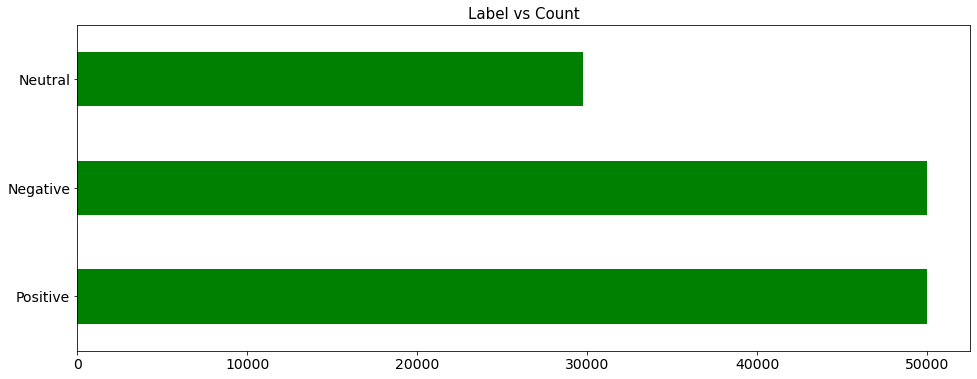

In [42]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="green",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Down sampling (remove some positive and negative reviews)

In [11]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

### Target distribution (after)

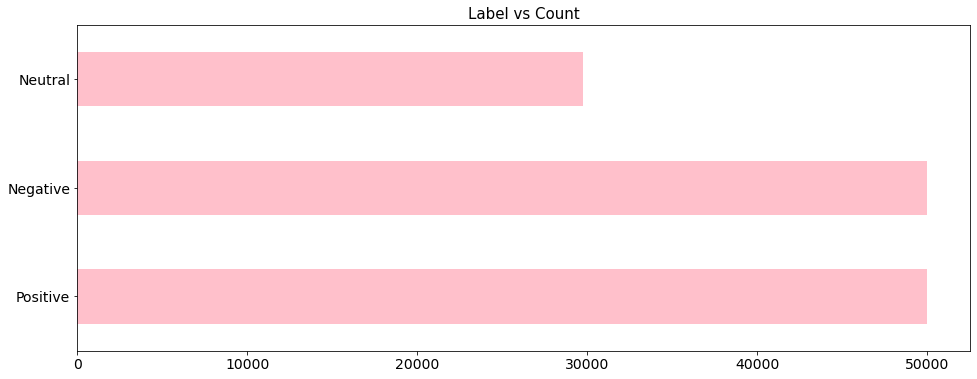

In [43]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="pink",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

# Data Pre-processing

### Stop words

In [13]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'can', 'few', 'didn', 'it', 'been', 'about', 'out', 'herself', 'ain', 'should', 'we', 'shouldn', 'where', 'through', 'before', 'll', "it's", 'is', 'own', 'do', 'couldn', 'what', 'him', 'when', 's', 'such', 'yourselves', 'our', 'these', 'during', 'all', 'i', 'theirs', 'some', 'has', 'aren', 'in', 'my', 'they', 'that', 'weren', 'wasn', 'its', 'doesn', 'who', "that'll", 'as', 'or', 'if', 'both', 'whom', 'needn', 'because', "she's", 'why', 'of', 'same', 'further', 'themselves', 'down', 'which', 'mightn', 'haven', 'mustn', 'does', 'other', 'her', 'myself', 'was', 'until', 'a', 'one', 'am', 'ours', 'than', "you're", 'into', 'd', 'only', 't', 'their', 'and', 'over', 'while', 'for', 'most', 'by', 'he', 'once', 'isn', 'shan', 'having', 'are', 'against', 'too', 'hers', 'your', 'on', 'won', 'me', 'she', 'with', 'up', 've', 'each', 'being', 'under', 'o', "you'll", 'hasn', 'himself', 'between', 'this', 'how', 'very', 'be', 'at', 'after', 'you', 'yours', 'off', 'just', 'below', 'don', "should've", 

### Remove unwanted words from reviews
#### Ex. html tags, punctuation, stop words, etc..

In [14]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [15]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

In [16]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


"Our 1 year old bassett/bulldog puppy played with this toy for 2 hours straight, the day we got it.  She chews a lot and it's hard to find toys that keep her attention.  This toy has been great! We put the rawhides on every few days.  It keeps the toy interesting.  She is getting much faster at eating the rawhide or unscrewing the end of the bone to get it off, but it's still a fun toy for her.  It is heavy and good quality, even though she has bite marks on the bone ends.  I don't mind buying the replacement rawhides, because it's extending the use of this toy."

In [17]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[6]   

After preprocessing : 


'year old bassettbulldog puppi play toy hour straight day got chew lot hard find toy keep attent toy great put rawhid everi day keep toy interest get much faster eat rawhid unscrew end bone get still fun toy heavi good qualiti even though bite mark bone end dont mind buy replac rawhid extend use toy'

# Word clouds

In [18]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

### Word cloud for Positive reviews

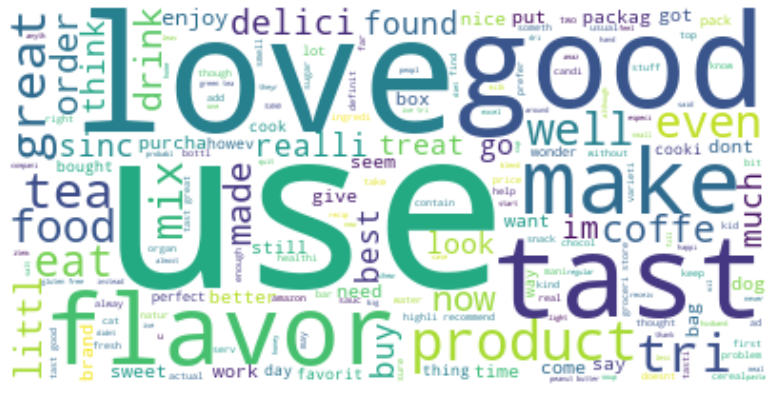

In [19]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Negative reviews

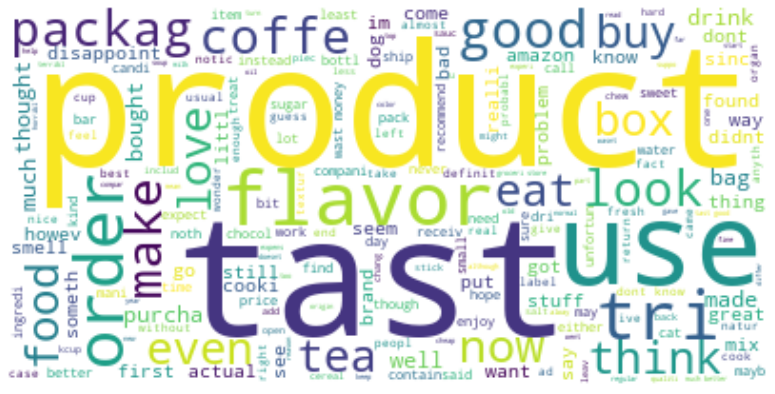

In [20]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Neutral reviews

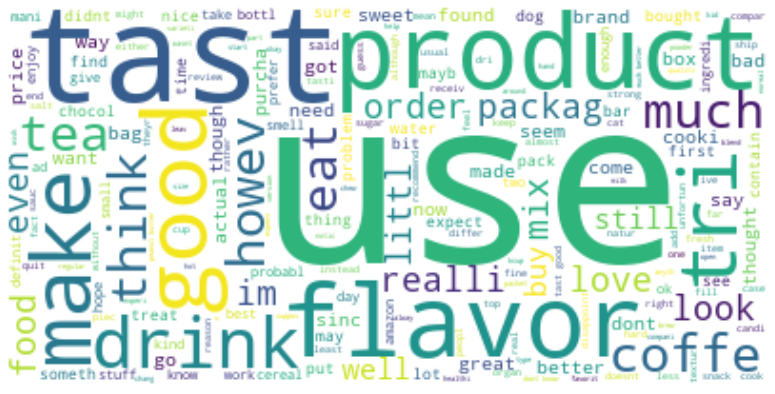

In [21]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

# Train Test Split

#### Train set : 70% of data
#### Test set : 30% of data

In [22]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [23]:
X_train.shape, X_test.shape

((103816,), (25954,))

# Vectorization

### Bag of Words Vectorizer

In [24]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

### TF-IDF Vectorizer

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

###  Label Encoding

In [26]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


# 4. Model Training

In [27]:
### 
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

## Logistic Regression with BoW

In [28]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6986687986437543
Test accuracy score : 0.6918394081837096

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.7378246127764506
Test accuracy score : 0.7163828311628265

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7659031363181013
Test accuracy score : 0.7172304847037065

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.787065577560299
Test accuracy score : 0.7071742313323572

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7929317253602528
Test accuracy score : 0.6958850273560916

 ----------------------------------------


## Naive Bayes Classifier with BoW

In [29]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7078196039146182
Test accuracy score : 0.6824766895276257

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.70699121522694
Test accuracy score : 0.6837096401325422

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7066829775757109
Test accuracy score : 0.6840949371965785

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7064999614702936
Test accuracy score : 0.683940818370964

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7063169453648763
Test accuracy score : 0.683940818370964

 ----------------------------------------


## Logistic Regression with Tf-Idf

In [30]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.644544193573245
Test accuracy score : 0.6409416660245049

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.6781517299838176
Test accuracy score : 0.6728442629267165

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7316309624720659
Test accuracy score : 0.7156892964475611

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7635431918008785
Test accuracy score : 0.7243584803883795

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7862179240194189
Test accuracy score : 0.7108730831471064

 ----------------------------------------


## Naive Bayes classifier with Tf-Idf

In [31]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7146778916544656
Test accuracy score : 0.6833243430685059

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7129055251598982
Test accuracy score : 0.685636125452724

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7104588888032674
Test accuracy score : 0.685636125452724

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7089080681205209
Test accuracy score : 0.6855590660399168

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7073668798643754
Test accuracy score : 0.685751714571935

 ----------------------------------------


# 5. Model Evaluation

In [32]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

### Best model : Logistic Regression(C=1) with TfIdf data

In [33]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)    

LogisticRegression(C=1, max_iter=500, random_state=1)

In [34]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

### Accuracy

In [35]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.7635431918008785
Test accuracy score : 0.7243584803883795


### Confusion Matrix

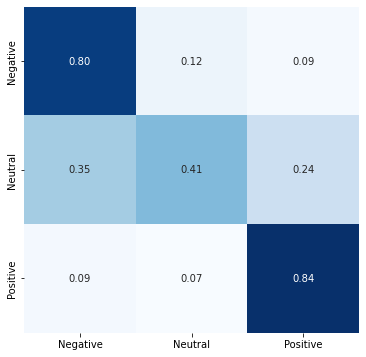

In [36]:
plot_cm(y_test, y_preds_test)

### Observations

#### - Our model is performing better on classifying positive and negative reviews.
#### - Need improvement in classifying the neutral reviews (Any suggestions??)

# 6. Deployment

### Prediction on single review

In [38]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [39]:
# positve review
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [40]:
# positve review
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!
